In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Concatinating flood defence csv's,and adding the flood defence column
correct_defences = pd.read_csv('defenceStats.csv', index_col=0)
not_defences = pd.read_csv('notDefenceStats.csv', index_col=0)
correct_defences['Flood_Defence'] = 1
not_defences['Flood_Defence'] = 0

classified_defences = pd.concat([correct_defences, not_defences])
classified_defences = classified_defences.reset_index(drop=True)
classified_defences = classified_defences.drop(columns=['geometry']).dropna().reset_index(drop=True) #Geometry needs to be dropped so next section works
classified_defences

,DEM_Mean,DEM_std,HAND_Mean,HAND_range,HAND_std,GSW_Mean,GSW_Euc_Mean,GFP_Euc_Mean,Flood_Defence
0,36.979827,4.960604,3.291142,18.200001,4.341024,0.634162,2.566344,0.0,1
1,2502.468550,40.629118,30.632834,135.199951,34.720010,0.000234,25.958859,0.0,1
2,19.662748,10.058917,10.721101,33.200001,9.386420,0.598180,3.041053,0.0,1
3,5.182774,1.789978,1.666125,14.599999,2.175888,0.226041,8.672798,0.0,1
4,12.954246,6.877830,5.151436,23.299999,5.598001,0.010865,15.069663,0.0,1
...,...,...,...,...,...,...,...,...,...
359,79.103277,2.245127,3.479871,9.799995,2.357751,0.009307,29.524546,2.0,0
360,22.329968,26.270278,18.797207,158.100006,26.408917,0.548082,4.028655,0.0,0
361,499.265654,5.712123,5.939206,22.600006,4.614945,0.002107,25.765087,0.0,0
362,69.515755,0.707299,0.907682,5.500000,1.054687,0.071895,9.844347,2.0,0


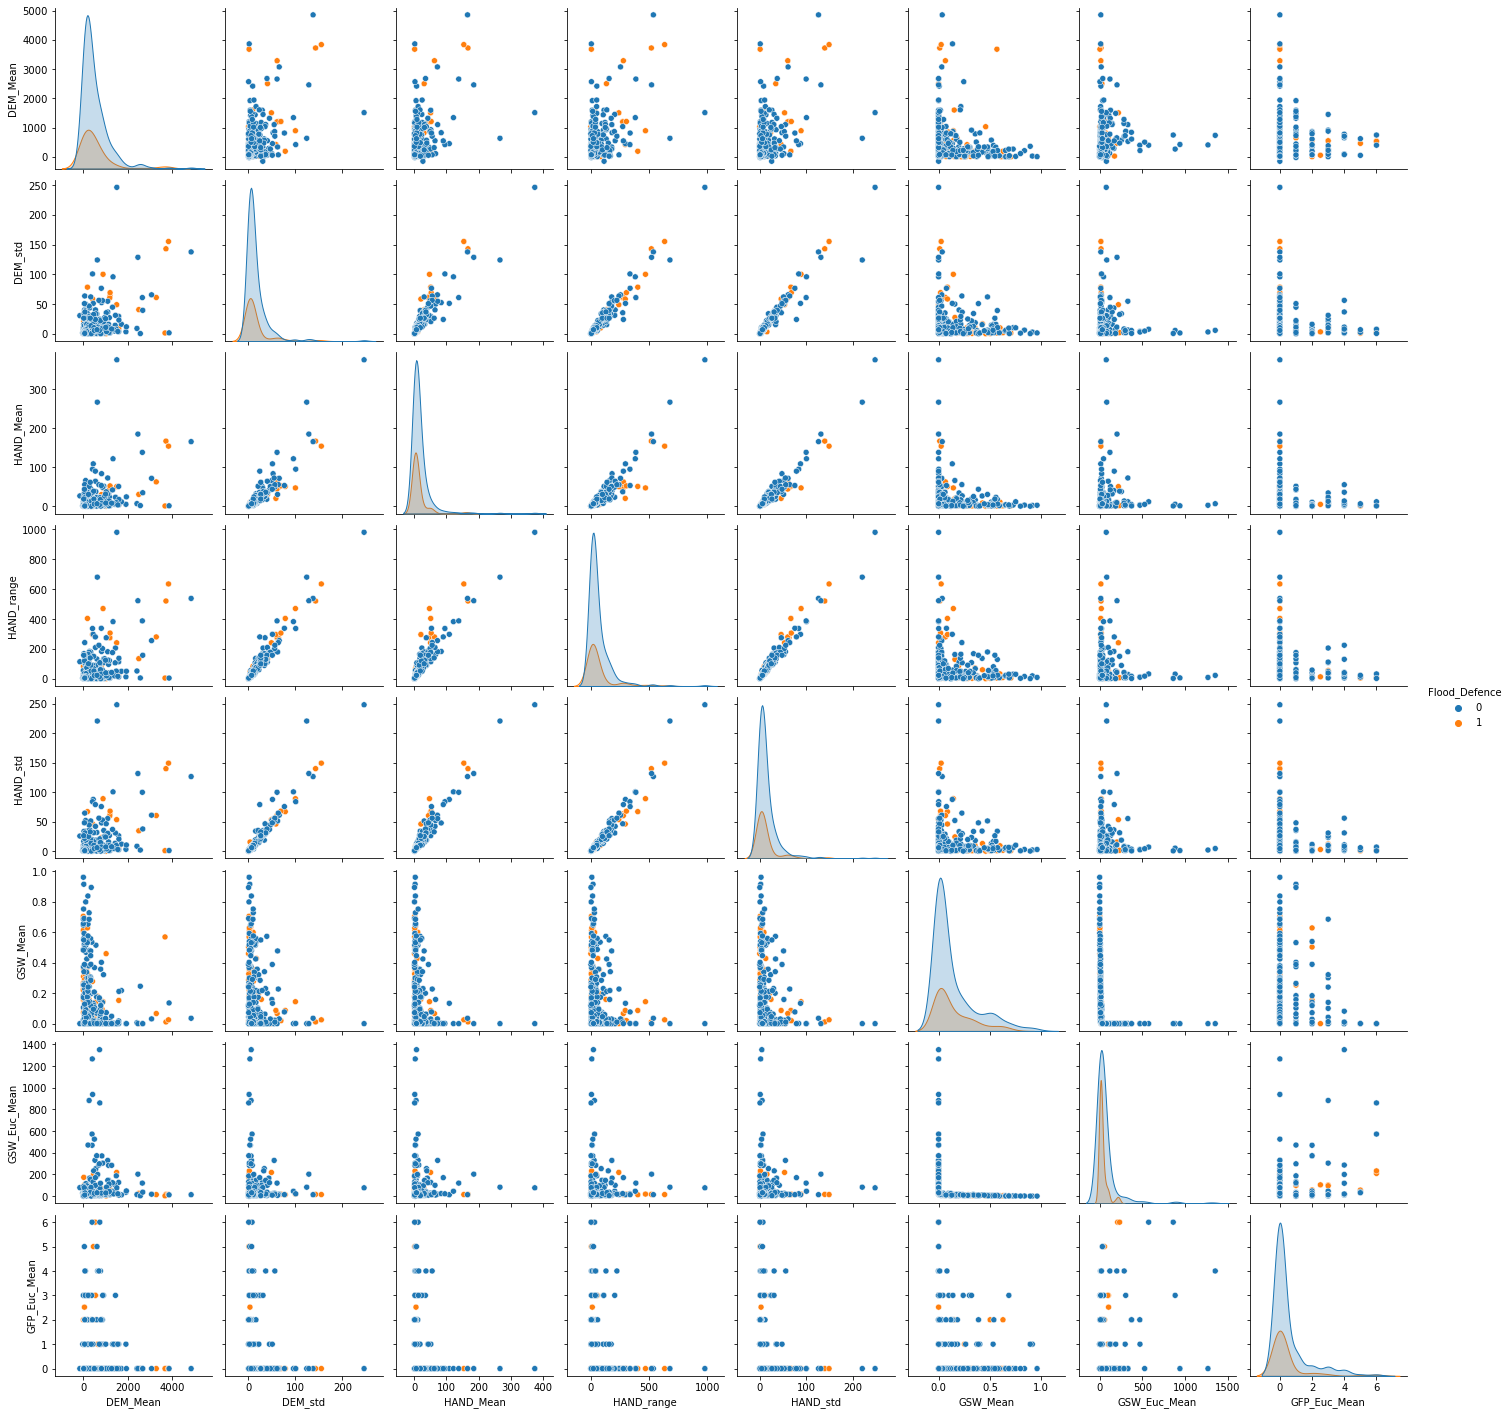

In [3]:
sns.pairplot(classified_defences, hue = 'Flood_Defence')
plt.show()

__Random Forest__

In [4]:
#Splitting data into training and testing data
classified_defences = classified_defences.dropna().reset_index(drop=True)
X = classified_defences.drop('Flood_Defence', axis=1)
y = classified_defences['Flood_Defence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
classified_rf = RandomForestClassifier(random_state=42, max_depth=5)
classified_rf = classified_rf.fit(X_train, y_train)

__Cross Validation__

In [6]:
# 5-Fold Cross validation
scores = cross_val_score(classified_rf, X_train, y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.75 accuracy with a standard deviation of 0.02


__Realtive Imprtance__

In [7]:
importances = classified_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in classified_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
print("feature 0.DEM Mean \nfeature 1.Dem Std \nfeature 4.GSW Euc Mean \nfeature 2.HAND Mean \nfeature 3.GSW Mean")

Feature ranking:
1. feature 0 (0.168554)
2. feature 1 (0.160854)
3. feature 4 (0.154612)
4. feature 2 (0.144433)
5. feature 3 (0.131679)
6. feature 6 (0.129047)
7. feature 5 (0.076244)
8. feature 7 (0.034577)
feature 0.DEM Mean 
feature 1.Dem Std 
feature 4.GSW Euc Mean 
feature 2.HAND Mean 
feature 3.GSW Mean


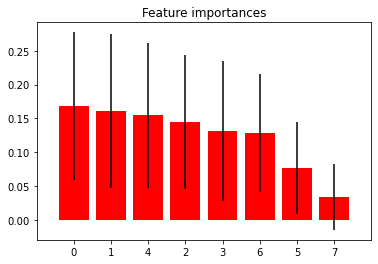

In [8]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

__Accuracy__

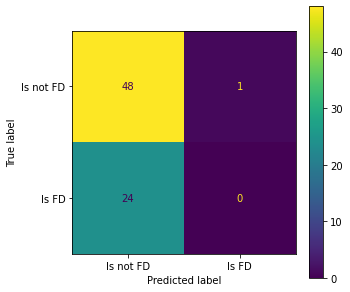

In [9]:
plt.rcParams['figure.figsize'] = [5, 5]

#Random Forest
plot_confusion_matrix(classified_rf, X_test, y_test, display_labels=["Is not FD", "Is FD"])

In [10]:
pred_rf = classified_rf.predict(X_test)
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.67      0.98      0.79        49
           1       0.00      0.00      0.00        24

    accuracy                           0.66        73
   macro avg       0.33      0.49      0.40        73
weighted avg       0.45      0.66      0.53        73



__Partial Dependency Plots__

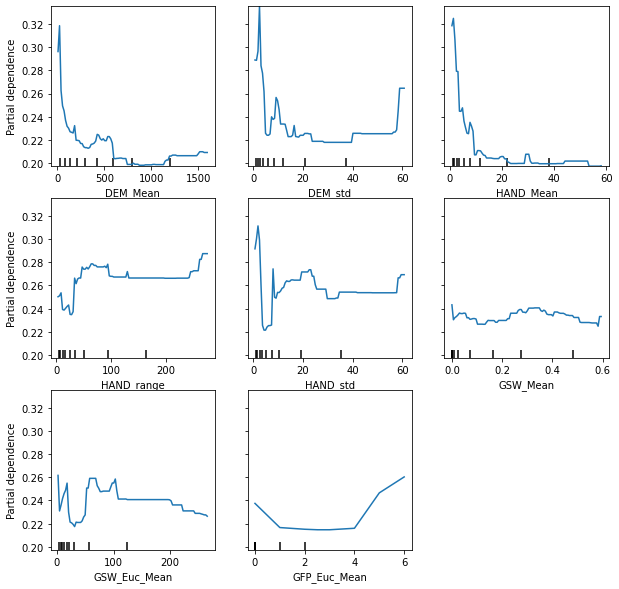

In [11]:
plt.rcParams['figure.figsize'] = [10, 10]
plot_partial_dependence(classified_rf, X, X.columns)

__Classifying Full Dataset__

In [12]:
all_stats = pd.read_csv('allPointsStats.csv', index_col=0)
tags = pd.read_csv('flood_def_table.csv', index_col=0, low_memory=False)
tags = tags.reset_index()
tags

,osm_id,name,highway,waterway,aerialway,barrier,man_made,embankment,meadow,tiger_name,z_order,other_tags,Shape_Leng
0,23698389,Ruta Nacional A011,primary,NaN,NaN,NaN,embankment,NaN,NaN,NaN,7,"""ref""=>""RNA011"",""lanes""=>""2"",""oneway""=>""no"",""o...",0.049154
1,77114947,Terraplén Rincón Oeste,residential,NaN,NaN,NaN,dyke,NaN,NaN,NaN,3,NaN,0.056059
2,79378359,Terraplén,unclassified,NaN,NaN,NaN,dyke,NaN,NaN,NaN,3,"""surface""=>""ground""",0.029577
3,88143352,NaN,NaN,NaN,NaN,NaN,dyke,NaN,NaN,NaN,0,NaN,0.065377
4,95633995,Estrada do Dique,tertiary,NaN,NaN,NaN,dyke,yes,NaN,NaN,4,"""ref""=>""ES-469"",""oneway""=>""no"",""surface""=>""unp...",0.024600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128855,860099966,NaN,NaN,NaN,NaN,NaN,embankment,NaN,NaN,NaN,0,NaN,0.001100
128856,860352323,NaN,NaN,NaN,NaN,NaN,dyke,NaN,NaN,NaN,0,NaN,0.007684
128857,860352324,NaN,NaN,NaN,NaN,NaN,dyke,NaN,NaN,NaN,0,NaN,0.006673
128858,860372133,NaN,NaN,NaN,NaN,NaN,embankment,NaN,NaN,NaN,0,NaN,0.000486


In [13]:
all_defences = pd.concat([all_stats, tags], axis=1)
all_defences

,geometry,DEM_Mean,DEM_std,HAND_Mean,HAND_range,HAND_std,GSW_Mean,GSW_Euc_Mean,GFP_Euc_Mean,osm_id,...,waterway,aerialway,barrier,man_made,embankment,meadow,tiger_name,z_order,other_tags,Shape_Leng
0,POLYGON ((-57.69124326965778 -25.3239363662802...,58.002238,1.413292,1.780488,4.800003,1.509760,0.320319,1.562112,0.0,23698389,...,NaN,NaN,NaN,embankment,NaN,NaN,NaN,7,"""ref""=>""RNA011"",""lanes""=>""2"",""oneway""=>""no"",""o...",0.049154
1,POLYGON ((-60.57260944801033 -31.5815560786866...,14.372639,2.022356,1.561021,6.800000,1.452149,0.502617,3.481055,0.0,77114947,...,NaN,NaN,NaN,dyke,NaN,NaN,NaN,3,NaN,0.056059
2,POLYGON ((-60.60242608178021 -31.6302482596922...,14.897376,2.605025,1.900233,8.700000,2.021614,0.448305,3.870029,0.0,79378359,...,NaN,NaN,NaN,dyke,NaN,NaN,NaN,3,"""surface""=>""ground""",0.029577
3,"POLYGON ((-74.74284375625786 10.5428592607567,...",5.539737,2.322363,1.819415,9.700000,2.197477,0.334697,13.045236,0.0,88143352,...,NaN,NaN,NaN,dyke,NaN,NaN,NaN,0,NaN,0.065377
4,POLYGON ((-40.3451217831535 -20.38856024334711...,-0.588551,2.319468,0.648843,18.100000,1.884937,0.189612,6.216272,0.0,95633995,...,NaN,NaN,NaN,dyke,yes,NaN,NaN,4,"""ref""=>""ES-469"",""oneway""=>""no"",""surface""=>""unp...",0.024600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128855,"POLYGON ((127.1748091509875 37.71805129808843,...",66.977631,30.790277,19.111112,149.400009,27.300939,0.008565,17.529881,0.0,860099966,...,NaN,NaN,NaN,embankment,NaN,NaN,NaN,0,NaN,0.001100
128856,"POLYGON ((121.3853380911081 23.69433954396141,...",274.877688,80.774182,54.977363,330.100037,73.611910,0.140706,11.371095,0.0,860352323,...,NaN,NaN,NaN,dyke,NaN,NaN,NaN,0,NaN,0.007684
128857,"POLYGON ((121.3894038770628 23.69419779529136,...",241.082929,53.329679,29.396750,191.300003,39.979375,0.162582,9.056218,0.0,860352324,...,NaN,NaN,NaN,dyke,NaN,NaN,NaN,0,NaN,0.006673
128858,"POLYGON ((48.04761250063359 56.50181830862562,...",111.666705,9.547539,11.454682,37.300003,11.144146,0.000956,19.957821,0.0,860372133,...,NaN,NaN,NaN,embankment,NaN,NaN,NaN,0,NaN,0.000486


In [14]:
all_defences = all_defences.drop(columns=['name', 'highway', 'osm_id', 'aerialway', 'barrier', 'z_order', 'other_tags', 'Shape_Leng'])
all_defences

,geometry,DEM_Mean,DEM_std,HAND_Mean,HAND_range,HAND_std,GSW_Mean,GSW_Euc_Mean,GFP_Euc_Mean,waterway,man_made,embankment,meadow,tiger_name
0,POLYGON ((-57.69124326965778 -25.3239363662802...,58.002238,1.413292,1.780488,4.800003,1.509760,0.320319,1.562112,0.0,NaN,embankment,NaN,NaN,NaN
1,POLYGON ((-60.57260944801033 -31.5815560786866...,14.372639,2.022356,1.561021,6.800000,1.452149,0.502617,3.481055,0.0,NaN,dyke,NaN,NaN,NaN
2,POLYGON ((-60.60242608178021 -31.6302482596922...,14.897376,2.605025,1.900233,8.700000,2.021614,0.448305,3.870029,0.0,NaN,dyke,NaN,NaN,NaN
3,"POLYGON ((-74.74284375625786 10.5428592607567,...",5.539737,2.322363,1.819415,9.700000,2.197477,0.334697,13.045236,0.0,NaN,dyke,NaN,NaN,NaN
4,POLYGON ((-40.3451217831535 -20.38856024334711...,-0.588551,2.319468,0.648843,18.100000,1.884937,0.189612,6.216272,0.0,NaN,dyke,yes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128855,"POLYGON ((127.1748091509875 37.71805129808843,...",66.977631,30.790277,19.111112,149.400009,27.300939,0.008565,17.529881,0.0,NaN,embankment,NaN,NaN,NaN
128856,"POLYGON ((121.3853380911081 23.69433954396141,...",274.877688,80.774182,54.977363,330.100037,73.611910,0.140706,11.371095,0.0,NaN,dyke,NaN,NaN,NaN
128857,"POLYGON ((121.3894038770628 23.69419779529136,...",241.082929,53.329679,29.396750,191.300003,39.979375,0.162582,9.056218,0.0,NaN,dyke,NaN,NaN,NaN
128858,"POLYGON ((48.04761250063359 56.50181830862562,...",111.666705,9.547539,11.454682,37.300003,11.144146,0.000956,19.957821,0.0,NaN,embankment,NaN,NaN,NaN


In [15]:
stat_headers = ['DEM_Mean', 'DEM_std', 'HAND_Mean', 'HAND_range', 'HAND_std', 'GSW_Mean', 'GSW_Euc_Mean', 'GFP_Euc_Mean']

for header in stat_headers:
    all_defences = all_defences[all_defences[header].notna()]

all_defences =all_defences.reset_index(drop=True)
all_defences

,geometry,DEM_Mean,DEM_std,HAND_Mean,HAND_range,HAND_std,GSW_Mean,GSW_Euc_Mean,GFP_Euc_Mean,waterway,man_made,embankment,meadow,tiger_name
0,POLYGON ((-57.69124326965778 -25.3239363662802...,58.002238,1.413292,1.780488,4.800003,1.509760,0.320319,1.562112,0.0,NaN,embankment,NaN,NaN,NaN
1,POLYGON ((-60.57260944801033 -31.5815560786866...,14.372639,2.022356,1.561021,6.800000,1.452149,0.502617,3.481055,0.0,NaN,dyke,NaN,NaN,NaN
2,POLYGON ((-60.60242608178021 -31.6302482596922...,14.897376,2.605025,1.900233,8.700000,2.021614,0.448305,3.870029,0.0,NaN,dyke,NaN,NaN,NaN
3,"POLYGON ((-74.74284375625786 10.5428592607567,...",5.539737,2.322363,1.819415,9.700000,2.197477,0.334697,13.045236,0.0,NaN,dyke,NaN,NaN,NaN
4,POLYGON ((-40.3451217831535 -20.38856024334711...,-0.588551,2.319468,0.648843,18.100000,1.884937,0.189612,6.216272,0.0,NaN,dyke,yes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128331,"POLYGON ((127.1748091509875 37.71805129808843,...",66.977631,30.790277,19.111112,149.400009,27.300939,0.008565,17.529881,0.0,NaN,embankment,NaN,NaN,NaN
128332,"POLYGON ((121.3853380911081 23.69433954396141,...",274.877688,80.774182,54.977363,330.100037,73.611910,0.140706,11.371095,0.0,NaN,dyke,NaN,NaN,NaN
128333,"POLYGON ((121.3894038770628 23.69419779529136,...",241.082929,53.329679,29.396750,191.300003,39.979375,0.162582,9.056218,0.0,NaN,dyke,NaN,NaN,NaN
128334,"POLYGON ((48.04761250063359 56.50181830862562,...",111.666705,9.547539,11.454682,37.300003,11.144146,0.000956,19.957821,0.0,NaN,embankment,NaN,NaN,NaN


In [16]:
all_defences_rf = all_defences.drop(columns=['geometry', 'waterway', 'man_made', 'embankment', 'meadow', 'tiger_name' ])
all_defences_rf

,DEM_Mean,DEM_std,HAND_Mean,HAND_range,HAND_std,GSW_Mean,GSW_Euc_Mean,GFP_Euc_Mean
0,58.002238,1.413292,1.780488,4.800003,1.509760,0.320319,1.562112,0.0
1,14.372639,2.022356,1.561021,6.800000,1.452149,0.502617,3.481055,0.0
2,14.897376,2.605025,1.900233,8.700000,2.021614,0.448305,3.870029,0.0
3,5.539737,2.322363,1.819415,9.700000,2.197477,0.334697,13.045236,0.0
4,-0.588551,2.319468,0.648843,18.100000,1.884937,0.189612,6.216272,0.0
...,...,...,...,...,...,...,...,...
128331,66.977631,30.790277,19.111112,149.400009,27.300939,0.008565,17.529881,0.0
128332,274.877688,80.774182,54.977363,330.100037,73.611910,0.140706,11.371095,0.0
128333,241.082929,53.329679,29.396750,191.300003,39.979375,0.162582,9.056218,0.0
128334,111.666705,9.547539,11.454682,37.300003,11.144146,0.000956,19.957821,0.0


In [17]:
X_all_rf = all_defences_rf
y_all_rf = classified_rf.predict(X_all_rf)

In [18]:
y_all_rf

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [19]:
all_defences['Flood_Defence']= pd.Series(y_all_rf)
all_defences

,geometry,DEM_Mean,DEM_std,HAND_Mean,HAND_range,HAND_std,GSW_Mean,GSW_Euc_Mean,GFP_Euc_Mean,waterway,man_made,embankment,meadow,tiger_name,Flood_Defence
0,POLYGON ((-57.69124326965778 -25.3239363662802...,58.002238,1.413292,1.780488,4.800003,1.509760,0.320319,1.562112,0.0,NaN,embankment,NaN,NaN,NaN,0
1,POLYGON ((-60.57260944801033 -31.5815560786866...,14.372639,2.022356,1.561021,6.800000,1.452149,0.502617,3.481055,0.0,NaN,dyke,NaN,NaN,NaN,0
2,POLYGON ((-60.60242608178021 -31.6302482596922...,14.897376,2.605025,1.900233,8.700000,2.021614,0.448305,3.870029,0.0,NaN,dyke,NaN,NaN,NaN,1
3,"POLYGON ((-74.74284375625786 10.5428592607567,...",5.539737,2.322363,1.819415,9.700000,2.197477,0.334697,13.045236,0.0,NaN,dyke,NaN,NaN,NaN,1
4,POLYGON ((-40.3451217831535 -20.38856024334711...,-0.588551,2.319468,0.648843,18.100000,1.884937,0.189612,6.216272,0.0,NaN,dyke,yes,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128331,"POLYGON ((127.1748091509875 37.71805129808843,...",66.977631,30.790277,19.111112,149.400009,27.300939,0.008565,17.529881,0.0,NaN,embankment,NaN,NaN,NaN,0
128332,"POLYGON ((121.3853380911081 23.69433954396141,...",274.877688,80.774182,54.977363,330.100037,73.611910,0.140706,11.371095,0.0,NaN,dyke,NaN,NaN,NaN,0
128333,"POLYGON ((121.3894038770628 23.69419779529136,...",241.082929,53.329679,29.396750,191.300003,39.979375,0.162582,9.056218,0.0,NaN,dyke,NaN,NaN,NaN,0
128334,"POLYGON ((48.04761250063359 56.50181830862562,...",111.666705,9.547539,11.454682,37.300003,11.144146,0.000956,19.957821,0.0,NaN,embankment,NaN,NaN,NaN,0


In [20]:
all_defences['Flood_Defence'].value_counts()

0    126273
1      2063
Name: Flood_Defence, dtype: int64

In [21]:
all_defences["Flood_Defence"].replace({1:"Defence", 0:"Not Defence"}, inplace=True)
all_defences

,geometry,DEM_Mean,DEM_std,HAND_Mean,HAND_range,HAND_std,GSW_Mean,GSW_Euc_Mean,GFP_Euc_Mean,waterway,man_made,embankment,meadow,tiger_name,Flood_Defence
0,POLYGON ((-57.69124326965778 -25.3239363662802...,58.002238,1.413292,1.780488,4.800003,1.509760,0.320319,1.562112,0.0,NaN,embankment,NaN,NaN,NaN,Not Defence
1,POLYGON ((-60.57260944801033 -31.5815560786866...,14.372639,2.022356,1.561021,6.800000,1.452149,0.502617,3.481055,0.0,NaN,dyke,NaN,NaN,NaN,Not Defence
2,POLYGON ((-60.60242608178021 -31.6302482596922...,14.897376,2.605025,1.900233,8.700000,2.021614,0.448305,3.870029,0.0,NaN,dyke,NaN,NaN,NaN,Defence
3,"POLYGON ((-74.74284375625786 10.5428592607567,...",5.539737,2.322363,1.819415,9.700000,2.197477,0.334697,13.045236,0.0,NaN,dyke,NaN,NaN,NaN,Defence
4,POLYGON ((-40.3451217831535 -20.38856024334711...,-0.588551,2.319468,0.648843,18.100000,1.884937,0.189612,6.216272,0.0,NaN,dyke,yes,NaN,NaN,Defence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128331,"POLYGON ((127.1748091509875 37.71805129808843,...",66.977631,30.790277,19.111112,149.400009,27.300939,0.008565,17.529881,0.0,NaN,embankment,NaN,NaN,NaN,Not Defence
128332,"POLYGON ((121.3853380911081 23.69433954396141,...",274.877688,80.774182,54.977363,330.100037,73.611910,0.140706,11.371095,0.0,NaN,dyke,NaN,NaN,NaN,Not Defence
128333,"POLYGON ((121.3894038770628 23.69419779529136,...",241.082929,53.329679,29.396750,191.300003,39.979375,0.162582,9.056218,0.0,NaN,dyke,NaN,NaN,NaN,Not Defence
128334,"POLYGON ((48.04761250063359 56.50181830862562,...",111.666705,9.547539,11.454682,37.300003,11.144146,0.000956,19.957821,0.0,NaN,embankment,NaN,NaN,NaN,Not Defence


__Individual Tags__

In [22]:
#man_made
all_defences['man_made'].value_counts()

embankment    111883
dyke           15977
levee            128
dike              19
Embankment         1
Name: man_made, dtype: int64

In [23]:
#man_made=emabnkment 
man_embankment = all_defences[all_defences['man_made'].notna()]
man_embankment = man_embankment.loc[man_embankment['man_made'] == 'embankment']
man_embankment

,geometry,DEM_Mean,DEM_std,HAND_Mean,HAND_range,HAND_std,GSW_Mean,GSW_Euc_Mean,GFP_Euc_Mean,waterway,man_made,embankment,meadow,tiger_name,Flood_Defence
0,POLYGON ((-57.69124326965778 -25.3239363662802...,58.002238,1.413292,1.780488,4.800003,1.509760,0.320319,1.562112,0.0,NaN,embankment,NaN,NaN,NaN,Not Defence
9,POLYGON ((-58.86695402549481 -34.6576105851329...,24.313768,2.192078,3.337246,8.999999,2.072749,0.010332,28.393436,0.0,NaN,embankment,NaN,NaN,NaN,Not Defence
12,POLYGON ((-58.47754406774118 -51.7989514320092...,64.120423,8.807407,11.176401,35.900002,8.535187,0.011142,20.536325,8.0,NaN,embankment,NaN,NaN,NaN,Not Defence
13,POLYGON ((-58.47121130533844 -51.7994737235356...,63.072555,8.644257,11.234649,35.900002,8.744375,0.004272,19.965065,8.0,NaN,embankment,NaN,NaN,NaN,Not Defence
14,POLYGON ((-58.47342378168963 -51.8010654697743...,65.355402,8.034480,10.946272,35.900002,8.505407,0.010224,17.537769,8.0,NaN,embankment,NaN,NaN,NaN,Not Defence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128327,"POLYGON ((40.15130500526448 43.45736146200818,...",448.793181,140.738367,145.614405,509.000000,108.092105,0.000179,34.439549,0.0,NaN,embankment,NaN,NaN,NaN,Not Defence
128328,"POLYGON ((65.69254633788427 57.15722765468905,...",56.246662,3.788952,3.470209,13.499996,3.023921,0.577748,1.926273,0.0,NaN,embankment,yes,NaN,NaN,Not Defence
128329,"POLYGON ((65.69174854721325 57.15937150203337,...",56.822347,3.991715,3.928931,13.799999,3.164624,0.494225,2.556943,0.0,NaN,embankment,yes,NaN,NaN,Not Defence
128331,"POLYGON ((127.1748091509875 37.71805129808843,...",66.977631,30.790277,19.111112,149.400009,27.300939,0.008565,17.529881,0.0,NaN,embankment,NaN,NaN,NaN,Not Defence


<AxesSubplot:title={'center':'Man_Made = Embankment'}, ylabel='Number of Features'>

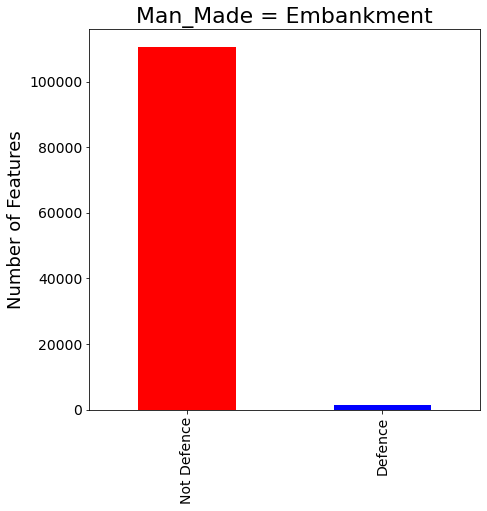

In [24]:
plt.rcParams['figure.figsize'] = [7, 7]
colors = ["r","b"]
plt.title('Man_Made = Embankment', fontsize = 22)
plt.ylabel('Number of Features', fontsize=18)
plt.xticks(rotation=90)
man_embankment['Flood_Defence'].value_counts().plot(kind="bar",color=colors, fontsize = 14)



In [25]:
#man_made=dyke
man_dyke = all_defences[all_defences['man_made'].notna()]
man_dyke = man_dyke.loc[man_dyke['man_made'] == 'dyke']
man_dyke

,geometry,DEM_Mean,DEM_std,HAND_Mean,HAND_range,HAND_std,GSW_Mean,GSW_Euc_Mean,GFP_Euc_Mean,waterway,man_made,embankment,meadow,tiger_name,Flood_Defence
1,POLYGON ((-60.57260944801033 -31.5815560786866...,14.372639,2.022356,1.561021,6.800000,1.452149,0.502617,3.481055,0.0,NaN,dyke,NaN,NaN,NaN,Not Defence
2,POLYGON ((-60.60242608178021 -31.6302482596922...,14.897376,2.605025,1.900233,8.700000,2.021614,0.448305,3.870029,0.0,NaN,dyke,NaN,NaN,NaN,Defence
3,"POLYGON ((-74.74284375625786 10.5428592607567,...",5.539737,2.322363,1.819415,9.700000,2.197477,0.334697,13.045236,0.0,NaN,dyke,NaN,NaN,NaN,Defence
4,POLYGON ((-40.3451217831535 -20.38856024334711...,-0.588551,2.319468,0.648843,18.100000,1.884937,0.189612,6.216272,0.0,NaN,dyke,yes,NaN,NaN,Defence
5,POLYGON ((-42.93819192511842 -22.6890951705140...,1.237580,0.335887,0.408586,1.300000,0.294009,0.011544,16.746265,0.0,NaN,dyke,NaN,NaN,NaN,Not Defence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128321,"POLYGON ((71.7839916536264 51.55324065277563, ...",306.957359,1.476506,1.216410,4.599976,0.960593,0.373253,2.793951,0.0,NaN,dyke,NaN,NaN,NaN,Not Defence
128330,"POLYGON ((70.38705938017608 24.54501907107243,...",38.940893,10.347383,12.459654,37.400002,9.865415,0.121429,23.189955,0.0,NaN,dyke,NaN,NaN,NaN,Not Defence
128332,"POLYGON ((121.3853380911081 23.69433954396141,...",274.877688,80.774182,54.977363,330.100037,73.611910,0.140706,11.371095,0.0,NaN,dyke,NaN,NaN,NaN,Not Defence
128333,"POLYGON ((121.3894038770628 23.69419779529136,...",241.082929,53.329679,29.396750,191.300003,39.979375,0.162582,9.056218,0.0,NaN,dyke,NaN,NaN,NaN,Not Defence


<AxesSubplot:title={'center':'Man_Made = Dyke'}, ylabel='Number of Features'>

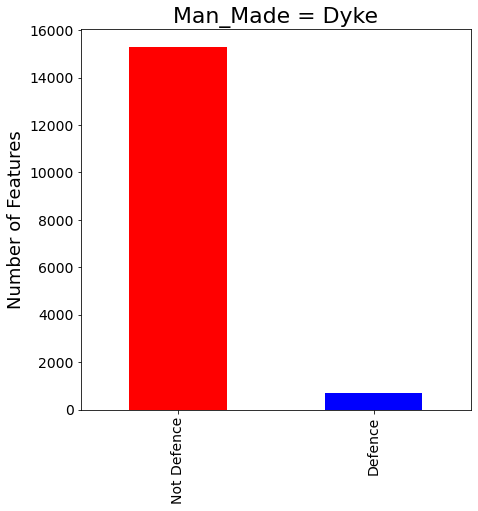

In [26]:
plt.rcParams['figure.figsize'] = [7, 7]
colors = ["r","b"]
plt.title('Man_Made = Dyke', fontsize = 22)
plt.ylabel('Number of Features', fontsize=18)
plt.xticks(rotation=90)
man_dyke['Flood_Defence'].value_counts().plot(kind="bar",color=colors, fontsize = 14)